In [10]:
import zipfile
import json
from collections import defaultdict

# Convert to ratio of True values to total count
def convert_to_floats(data):
    return {key: sum(values) / len(values) for key, values in data.items()}

def parse_validations(zip_ref, filename):
    """Extract and parse JSON file from within the ZIP archive."""
    with zip_ref.open(filename) as file:
        parsed = json.load(file)
        return parsed.get("validations", {})

def update_validator_counts(validator_counts, validations):
    """Update validator counts with new validation results."""
    for validator, result in validations.items():
        validator_counts[validator].append(result)
    return validator_counts

def is_test_result(filename):
    """Check if a filename corresponds to a test result file."""
    return filename.endswith('-True.json') or filename.endswith('-False.json') or filename.startswith('pass-') or filename.startswith('fail-')

def is_passing_result(filename):
    return filename.endswith('-True.json') or filename.startswith('pass-')

def count_json_files(zip_filepath):
    """Process JSON files inside a ZIP archive and count validation results."""
    true_counts = defaultdict(int)
    total_counts = defaultdict(int)
    validator_counts = defaultdict(list)  # validator name -> [True, False, ...]

    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            parts = filename.split('/')
            jsonname = parts[-1]

            # Ensure we are looking at JSON validation files
            if len(parts) > 2 and is_test_result(jsonname):
                validations = parse_validations(zip_ref, filename)
                validator_counts = update_validator_counts(validator_counts, validations)

                test_name = parts[-2].split('-')[0]
                total_counts[test_name] += 1
                if is_passing_result(jsonname):
                    true_counts[test_name] += 1

    # Print summary of results
    for test in total_counts:
        true_count = true_counts.get(test, 0)
        total_count = total_counts[test]
        # print(f"{test}: {true_count} True files / {total_count} total files")

    return convert_to_floats(validator_counts)

# Call the function with your ZIP file path
#count_json_files('/content/drive/Shareddrives/CAT/ai-reliability/test-output-40.zip')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# prompt: iterate over zip files and use above function to get reliability metrics for each test per run, run number in the zip file name

import zipfile
import os
import re
from collections import defaultdict

def get_run_number(filename):
    match = re.search(r"(\d+)\.zip", filename)
    if match:
        return int(match.group(1))
    return None

list_of_points = []

directory_path = '/content/drive/Shareddrives/CAT/ai-reliability/'  # Replace with your directory
for filename in os.listdir(directory_path):
    if filename.endswith(".zip"):
        filepath = os.path.join(directory_path, filename)
        run_number = get_run_number(filename)
        if run_number is not None:
            # print(f"Processing run number {run_number}:")
            counts = count_json_files(filepath)
            counts['Run'] = run_number
            list_of_points.append(counts)
            # print(counts)
        else:
            print(f"Could not determine run number for file: {filename}")


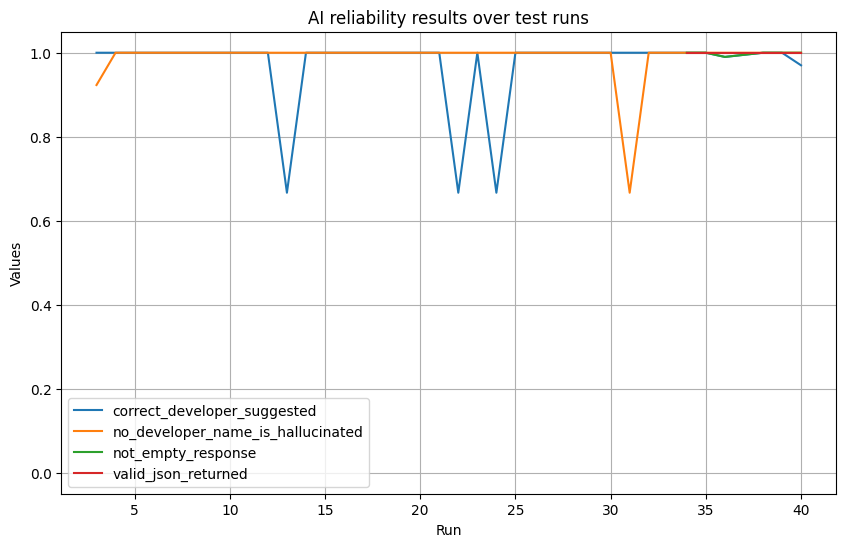

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(list_of_points)
df.sort_values(by=['Run'], inplace=True)

# Create the initial plot with 'Run' on the x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the data with a higher zorder
columns_to_plot = [col for col in df.columns if col != 'Run' and col != 'Iterations']
df.plot(x='Run', y=columns_to_plot, kind='line', ax=ax1)  # zorder set to 3

# Configure the primary y-axis
ax1.set_xlabel('Run')
ax1.set_ylim(-0.05, 1.05)
ax1.set_ylabel('Values')
ax1.grid(True)

# Set title and legend
plt.title('AI reliability results over test runs')
plt.legend()

# Show the plot
plt.show()